<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 execution

### Test file implementing BERT2BERT using Bert-Tiny model

Adapted the given example. Bert-Tiny can actually be runned with really ugly results, getting out of memory using 1000 samples.. works with 500.
Only 3 epochs used as said in the assignement.

### Important:
Looking at length of answers, spans and questions there are some super long (2000+ chars). But the 75% are under much much less (70 for the span). I tried to set a threshold to exclude them. In this way the batch size is much smaller, considering the useless padding. 
In this way, instead of 500 samples, can batch at least 2000

In [2]:
%pip install pandas numpy matplotlib transformers dataset tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data loading

### Dataset download

In [3]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')
    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [4]:
data_folder = 'Dataset'

In [5]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=data_folder, url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=data_folder, url_path=test_url, suffix='test')

### Dataset loading

In [6]:
import numpy as np
import pandas as pd
import json
from os import path
from matplotlib import pyplot as plt

In [7]:
def loadDataset(filename):
    with open(path.join(data_folder, filename)) as file_obj:
        df = json.load(file_obj)["data"]
    print(f'{len(df)} stories / {len(df[0]["questions"])} questions in the first row')

    storyDType = pd.CategoricalDtype(pd.unique([story["story"] for story in df]))
    sourceDType = pd.CategoricalDtype(pd.unique([story["source"] for story in df]))
    print(f"Sources: {sourceDType.categories}")

    df = np.array([
        [
            sourceDType.categories.get_loc(story["source"]), # Sources factorization
            storyDType.categories.get_loc(story["story"]), # Sources factorization
            story["questions"][question_index]["input_text"],
            story["answers"][question_index]["input_text"],
            story["answers"][question_index]["span_text"],
        ]
        for story in df
        for question_index in range(len(story["questions"]))
        if story["answers"][question_index]["input_text"] != 'unknown'
    ])
    print(f'{df.shape} question-answer pairs x columns')
    print(f'First row: {df[0]}')
    
    # https://marcobonzanini.com/2021/09/15/tips-for-saving-memory-with-pandas/
    # https://pandas.pydata.org/docs/user_guide/categorical.html
    df = pd.DataFrame({
        "source": pd.Series(pd.Categorical.from_codes(df[:,0].astype(np.int16), dtype=sourceDType)),
        "p": pd.Series(pd.Categorical.from_codes(df[:,1].astype(np.int16), dtype=storyDType)),
        "q": df[:,2],
        "a": df[:,3],
        "span": df[:,4],
    })

    return df

In [8]:
train_df = loadDataset("train.json")
train_df.count()

7199 stories / 20 questions in the first row
Sources: Index(['wikipedia', 'cnn', 'gutenberg', 'race', 'mctest'], dtype='object')
(107276, 5) question-answer pairs x columns
First row: ['0' '0' 'When was the Vat formally opened?'
 'It was formally established in 1475' 'Formally established in 1475']


source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

In [9]:
pd.unique(train_df["p"]).size

6605

In [10]:
pd.unique(train_df["span"]).size

99470

In [11]:
pd.unique(train_df["source"]).size

5

In [12]:
train_df.head()

,source,p,q,a,span
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi..."


In [13]:
train_df.memory_usage(deep=True)

Index          128
source      107764
p         14241201
q          9110271
a          7714559
span      12090637
dtype: int64

In [14]:
#test_df = loadDataset("test.json")
#test_df.count()

## Data Pre-Processing

### Check unanswerable questions in the Train Dataset

In [15]:
idx = (train_df.a == 'unknown')
unanswerable = train_df[idx]
unanswerable.q.count()

0

All unanswerable questions in the Train Dataset have been already removed.

## Exploratory Data Analysis

In [16]:
train_df["p"][42]

'CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n"Lassiter, will you be my rider?" Jane had asked him. \n\n"I reckon so," he had replied. \n\nFew as the words were, Jane knew how infinitely much they implied. She wanted him to take charge of her cattle and horse and ranges, and save them if that were possible. Yet, though she could not have spoken aloud all she meant, she was perfectly honest with herself. Whatever the price to be paid, she must keep Lassiter close to her; she must shield from him the man who had led Milly Erne to Cottonwoods. In her fear she so controlled her mind that she did not whisper this Mormon\'s name to her own soul, she did not even think it. Besides, beyond this thing she regarded as a sacred obligation thrust upon her, was the need of a helper, of a friend, of a champion in this critical time. If she could rule this gun-man, as Venters had called him, if she could even keep him from shedding blood, what strategy to play his flame and his presence against the g

In [17]:
train_df["q"][42]

'Was Lassiter impressed with the horse?'

In [18]:
train_df["a"][42]

'Yes'

In [19]:
train_df["span"][42]

'When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.'

In [20]:
train_df["source"][42]

'gutenberg'

## Plot of the length of question, span and answers.
Could try to set a threshold to have a maximum length to avoid useless padding.


In [21]:
length_df = pd.DataFrame({'question': train_df["q"].apply(lambda x: len(x)),
                          'span': train_df["span"].apply(lambda x: len(x)),
                          'answer': train_df["a"].apply(lambda x: len(x))})
length_df.describe()


,question,span,answer
count,107276.000000,107276.000000,107276.000000
mean,27.889183,53.330661,14.722874
std,13.550121,53.955215,17.286854
min,1.000000,1.000000,1.000000
25%,19.000000,21.000000,4.000000
50%,26.000000,40.000000,10.000000
75%,35.000000,70.000000,19.000000
max,229.000000,1936.000000,1819.000000


Considering span as the maximum category, 75% of data are under 70 chars.

In [22]:
print(length_df.loc[length_df['answer'] == np.max(length_df['answer'])])

# An answer of 1819 chars, equal to the span! Could be good to avoid
print(train_df["a"][80727])

       question  span  answer
80727         9  1819    1819
At the age of sixteen, I went on my first volunteer program in West Virginia to repair or build homes for poor families. When we arrived, we discovered that the family we were going to help was living in a trailer that was in poor condition, no bigger than two parking spaces. A group of people had been working on it for two weeks, but every time they finished one problem, another appeared. We soon decided that the only way was to build a new house. It was something unusual because normally our goal was to repair old homes. The family was pleased with their new house that was 20 by 30 feet with three bedrooms, a bath and a kitchen. On Tuesday of that week, I asked the family's three boys, Josh, Eric and Ryan, "What do you want for your new room?" Kids in the families we had helped usually wanted toys or posters, so we were surprised when Josh, the oldest boy said, "We just want beds." The boys had never slept in a bed. That nig

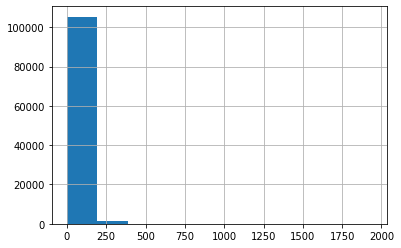

In [23]:
length_df['span'].hist()


In [24]:
# 81036 rows instead of 107276
length_cut_df = length_df.loc[length_df['span'] <= 70]

In [25]:
train_df = train_df.iloc[length_cut_df.index.values]
train_df.describe()

,source,p,q,a,span
count,81036,81036,81036,81036,81036
unique,5,6566,65302,50661,74935
top,race,"New York (CNN) -- A self-described ""ex-madam"" ...",Where?,yes,three
freq,19637,149,540,4939,39


## Train-Validation-Test split

In [26]:
# TODO

## Model definition

### Utilities

In [27]:
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable
import random

In [28]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [29]:
def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    #predictions on the x set
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    #compute the f1_macro
    score = f1_score(y, y_pred, average ='macro')
    return score

In [30]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [31]:
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm import tqdm
from copy import deepcopy
from transformers import TFAutoModel, AutoTokenizer, TFEncoderDecoderModel

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Question generation $f_\theta(P, Q)$ with text passage $P$ and question $Q$

BERT2BERT Bert-Tiny

In [32]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, keras_model):
        self.keras_model = keras_model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05)

    @tf.function
    def compute_loss(self, inputs):
        loss = self.keras_model(inputs=inputs)
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(inputs=inputs)

        grads = tape.gradient(loss, self.keras_model.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.keras_model.trainable_variables))
        return loss


class MyModel(tf.keras.Model):
    """
    Custom keras model that wraps the TFEncoderDecoderModel
    """

    def __init__(self, model_name, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.model_name = model_name

        # tie_encoder_decoder to share weights and half the number of parameters
        self.model = TFEncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name,
                                                                           encoder_from_pt=True,
                                                                           decoder_from_pt=True,
                                                                           tie_encoder_decoder=True)

    def call(self, inputs, **kwargs):
        loss = self.model(input_ids=inputs['input_ids'],
                          attention_mask=inputs['input_attention_mask'],
                          decoder_input_ids=inputs['decoder_input_ids'],
                          decoder_attention_mask=inputs['labels_mask'],
                          labels=inputs['labels']).loss
        return loss

    def generate(self, **kwargs):
        return self.model.generate(decoder_start_token_id=self.model.config.decoder.pad_token_id,
                                   **kwargs)


In [33]:
# Download the model only if not already present.
# Saving  it in ./models/

def get_tokenizer(model_name):  
    data_path = "models"  
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, model_name)
    if not os.path.exists(data_path):
        print(f"Downloading model {model_name}... (it may take a while)")
        tokenizer = AutoTokenizer.from_pretrained(model_name, tie_encoder_decoder=True)
        tokenizer.save_pretrained(data_path)
        print(f"Download completed, saved in {data_path}!")
    else:
        print(f'Model already downloaded, loading from {data_path}')
        tokenizer = AutoTokenizer.from_pretrained(data_path, tie_encoder_decoder=True)

    return tokenizer


In [34]:
model_name = 'prajjwal1/bert-tiny'

#tokenizer = get_tokenizer(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, tie_encoder_decoder=True)
model = MyModel(model_name=model_name)

model.model.config.decoder_start_token_id = tokenizer.cls_token_id
model.model.config_eos_token_id = tokenizer.sep_token_id
model.model.config.pad_token_id = tokenizer.pad_token_id
model.model.config.vocab_size = model.model.config.encoder.vocab_size

trainer = MyTrainer(keras_model=model)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [35]:
samples = 2000

sample_questions = list(train_df['q'][:samples])
sample_spans = list(train_df['span'][:samples])
sample_answers = list(train_df['a'][:samples])

len(max(sample_spans, key=len))


70

In [36]:
# input containing the question and the span
input_qs = tokenizer(sample_questions, sample_spans, padding=True)
input_ids, input_attention_mask = input_qs['input_ids'], input_qs['attention_mask']

# labels containing the answer
label_values = tokenizer(sample_answers, padding=True)
labels, labels_mask = label_values['input_ids'], label_values['attention_mask']

# Every labels has the same len, cause of padding=True
max_length = len(labels[0])

# Assigning id -100 to every padding token in labels
masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]

for idx in masked_labels[0]:
    print("{}\t{}".format(idx, tokenizer.convert_ids_to_tokens(idx) if idx != -100 else "PAD"))

101	[CLS]
2009	it
2001	was
6246	formally
2511	established
1999	in
16471	147
2629	##5
102	[SEP]
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD
-100	PAD


In [ ]:
epochs = 3
# batch_size = 32
# 

In [ ]:
generatedList = []

for epoch in tqdm(range(epochs)):
    #for batch in ...
    batch = {'input_ids': tf.convert_to_tensor(input_ids, dtype=tf.int32),
                'input_attention_mask': tf.convert_to_tensor(input_attention_mask, dtype=tf.int32),
                'labels': tf.convert_to_tensor(labels_mask, dtype=tf.int32),
                'decoder_input_ids': tf.convert_to_tensor(deepcopy(labels), dtype=tf.int32),
                'labels_mask': tf.convert_to_tensor(labels_mask, dtype=tf.int32)
                }
    loss = trainer.batch_fit(inputs=batch)
    print(f'Epoch {epoch} -- Loss {loss}')
    # You can play with generation arguments to enforce
    #  beam search
    #  repetition penalty
    #  other sampling approaches
    generated = trainer.keras_model.generate(input_ids=tf.convert_to_tensor(input_ids, dtype=tf.int32),
                                                max_length=max_length,
                                                repetition_penalty=3.,
                                                min_length=5,
                                                no_repeat_ngram_size=3,
                                                early_stopping=True,
                                                num_beams=4
                                                )
    generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
    print(f'Generated: {generated}')
    generatedList.append(generated)


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


Epoch 0 -- Loss 19.35713768005371


 33%|███▎      | 1/3 [48:57<1:37:54, 2937.28s/it]

Generated: [') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( back north ) west west west - south west - east east east - middle east east eastern - north east', ') ( ( back north ) west west west - south west - east east east - middle east east eastern - north east', ') ( ( water water ) water water and water water or, water water ; supply water water for prepared the by water', ') ( ( water water ) water water and water water or, water water ; supply water water for prepared the by water', ') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( water water ) water water and water water or, water water water

 67%|██████▋   | 2/3 [1:38:41<49:25, 2965.08s/it]

Generated: [') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( back north ) west west west - south west - east east east - middle east east eastern - north east', ') ( ( back north ) west west west - south west - east east east - middle east east eastern - north east', ') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( water water ) water water and water water or, water water water ; supply water water for prepared water water', ') ( ( back north ) west west west - east east east - south east east eastern - middle east east – east', ') ( ( water water ) water water and water water or, water water water ; 

# TODO - Model evaluation